## Nachrichten Überprüfung:
Diese Projekt beschäftig sich mit der Implementierung von Graph Neural Network (GNN) zur Erkennung von falsche Nachrichten.
Dataset: gossipcop-Dataset.
Tools= Pytoch-Geometric



In [24]:
import torch
torch.cuda.is_available = lambda: False
import torch_geometric
from torch_geometric.datasets import UPFD
import numpy as np

#Dowonload the Dataset:
TrainData = UPFD(root=".", name="gossipcop", feature="content", split="test")
TestData = UPFD(root=".", name="gossipcop", feature="content", split="train")

In [25]:
print("Datasetsname ist gossipcop-Dataset ")
print("Train-Data Laenge: ", len(TrainData))
print("Test-Data Laenge: ", len(TestData))

Datasetsname ist gossipcop-Dataset 
Train-Data Laenge:  3826
Test-Data Laenge:  1092


###### Sample-Anzeigen:

In [26]:
print("Probe-Id wird genomen:")
SampleID = 30
print("Probe-ID:\n", TrainData[SampleID].edge_index)

Probe-Id wird genomen:
Probe-ID:
 tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  6],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]])


###### Graphische-Darstellung:

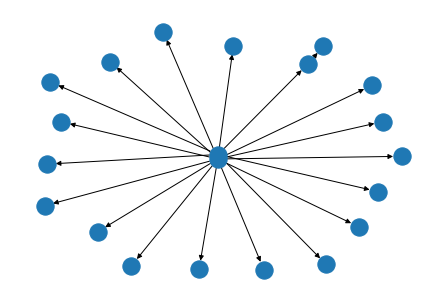

In [27]:
#Graphische-Darstellung der Dateset:

import networkx as nx

def ToNetworkx(data,
               node_attrs=None,
               edge_attrs=None,
               to_undirected=False,
               remove_self_loops=False):

    if to_undirected:
        Graph = nx.Graph()
    else:
        Graph = nx.DiGraph()

    Graph.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        Graph.add_edge(u, v)
        for key in edge_attrs:
            Graph[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in Graph.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return Graph


nx.draw ((ToNetworkx(TrainData[SampleID])))

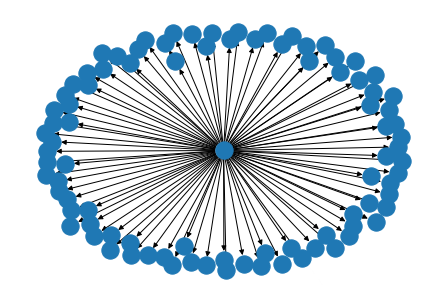

In [28]:
SampleID2=20
nx.draw ((ToNetworkx(TrainData[SampleID2])))

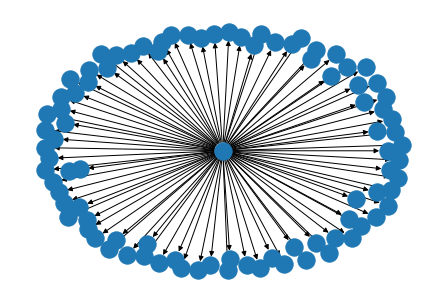

In [29]:
SampleID3=5
nx.draw ((ToNetworkx(TrainData[SampleID2])))

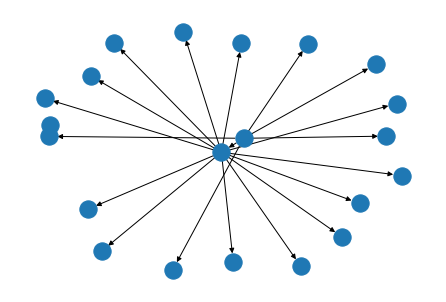

In [30]:
SampleID4=30
nx.draw ((ToNetworkx(TrainData[SampleID4])))

In [31]:
#Shape der Daten:
print("Shape von Train und Test Data: ")
print(TrainData[SampleID].x.shape)
print(TestData[SampleID].x.shape)

Shape von Train und Test Data: 
torch.Size([21, 310])
torch.Size([69, 310])


##### Model:

In [32]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(TrainData, batch_size=128, shuffle=True)
test_loader = DataLoader(TestData, batch_size=128, shuffle=False)

from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear

In [33]:
#Geometric-Modell:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()


        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        #Ablesen:
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2 * hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        h = self.lin0(h).relu()


        #Raw word2vec Einbettung von Nachrichten:
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))

        return torch.sigmoid(out)

print(GNN(TrainData.num_features, 128, 1))

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)


###### Training:

In [34]:
from sklearn.metrics import accuracy_score, f1_score
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = GNN(TrainData.num_features, 128, 1).to(Device)
Optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0.01)
LossFunktion = torch.nn.BCELoss()

In [35]:
# Trains- und Testsfunktion:

def train(epoch):
    Model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(Device)
        Optimizer.zero_grad()
        out = Model(data.x, data.edge_index, data.batch)
        loss = LossFunktion(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        Optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)



In [36]:
@torch.no_grad()
def test(epoch):
    Model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(Device)
        out = Model(data.x, data.edge_index, data.batch)
        loss = LossFunktion(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
        
    #Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1

In [37]:
def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [38]:
for epoch in range(45):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.72 | TestLoss: 0.69 | TestAcc: 0.52 | TestF1: 0.05
Epoch: 01 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.51 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.67 | TestLoss: 0.65 | TestAcc: 0.88 | TestF1: 0.89
Epoch: 03 |  TrainLoss: 0.66 | TestLoss: 0.68 | TestAcc: 0.51 | TestF1: 0.01
Epoch: 04 |  TrainLoss: 0.63 | TestLoss: 0.81 | TestAcc: 0.51 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.59 | TestLoss: 0.53 | TestAcc: 0.83 | TestF1: 0.85
Epoch: 06 |  TrainLoss: 0.52 | TestLoss: 0.46 | TestAcc: 0.91 | TestF1: 0.91
Epoch: 07 |  TrainLoss: 0.45 | TestLoss: 0.43 | TestAcc: 0.81 | TestF1: 0.76
Epoch: 08 |  TrainLoss: 0.42 | TestLoss: 0.43 | TestAcc: 0.76 | TestF1: 0.68
Epoch: 09 |  TrainLoss: 0.40 | TestLoss: 0.37 | TestAcc: 0.86 | TestF1: 0.83
Epoch: 10 |  TrainLoss: 0.34 | TestLoss: 0.32 | TestAcc: 0.92 | TestF1: 0.92
Epoch: 11 |  TrainLoss: 0.34 | TestLoss: 0.32 | TestAcc: 0.92 | TestF1: 0.92
Epoch: 12 |  TrainLoss: 0.34 | TestLoss: 0.33 | TestAcc: 0.88 | TestF1: 0.89

###### Prediction:

In [16]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(TrainData)]

In [20]:
## Prediction:
print("Prediction out Model:\n")
for data in test_loader:
    data = data.to(Device)
    pred = Model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["Prediction"] = pred.detach().numpy()[:,0]
    df["predictet"] = torch.round(pred).detach().numpy()[:,0]
    df["Richtig"] = data.y.numpy()
    print(df.head(11))
    break

Prediction out Model:

    Prediction  predictet  Richtig
0     0.075376        0.0        0
1     0.722959        1.0        1
2     0.985376        1.0        1
3     0.036683        0.0        0
4     0.059920        0.0        0
5     0.937484        1.0        1
6     0.784031        1.0        1
7     0.771753        1.0        1
8     0.108713        0.0        0
9     0.598780        1.0        1
10    0.036639        0.0        0


###### Modell-Speichern:

In [21]:
torch.save(Model.state_dict(), 'Nachrichten-Erkennung.pt')
print("Saving war Erfordereich..!!")

Saving war Erfordereich..!!


Das Modell kann weiter verwendet werden, um verschiedene Daten wie den zweiten Schwanz der UPFD-Daten namens "politifact" zu testen und so ein Modell zu erhalten, das später zum Testen der Nachrichten verwendet werden kann.

###### Ende des Projekts...